# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импортируем все необходимые библиотеки

In [ ]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn import tree

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Откроем файл

In [ ]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Изучим инфо

In [ ]:
df.shape

(3214, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Изменим тип на цельночисленный

In [ ]:
df['minutes'] = df['minutes'].astype('int')
df['calls'] = df['calls'].astype('int')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   int64  
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


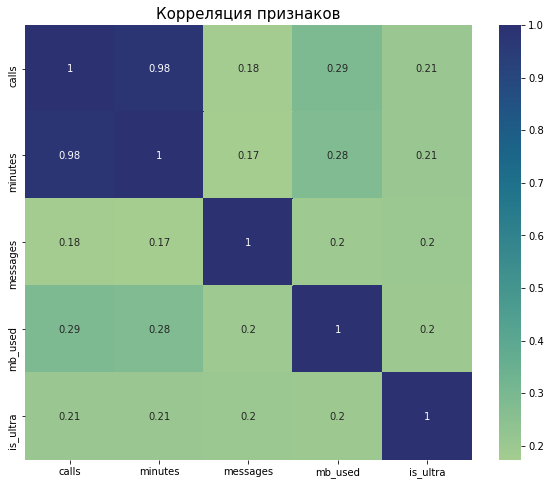

In [ ]:
plt.figure(figsize = (10, 8));
plt.title('Корреляция признаков', fontsize = 15)
sns.heatmap(df.corr(), annot = True, cmap="crest");

Видим сильную корреляцию между двумя признаками `calls` и `minutes`. В этом случае модель может давать хорошие результаты на обучающей выборке, но плохо работать с новым набором данных. При построении линейных моделей мультиколлинеарность может вызвать 2 типа проблем:
    
    -Оценки коэффициентов модели могут сильно колебаться в зависимости от других признаков.
    -Точность оценок коэффициентов снижается. Это затрудняет определение того, какие признаки на самом деле являются статистически значимыми.

Варианты решений:
    
    -можно удалить один из сильно коррелируемых признаков
    -объеденить два признака в один (создать новый столбец)
    -использовать методы специально разработанные для работы с сильно коррелированными переменными (метод наименьших квадратов, например).

## Разбейте данные на выборки

Извлечем целевой признак

In [ ]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)

In [ ]:
print('Размер обучающей выборки:', features_train.shape)

Размер обучающей выборки: (1928, 4)


In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(features_test, target_test, test_size=0.5, random_state=12345, stratify=target_test)

In [ ]:
print('Размер валидационной выборки:', features_valid.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер валидационной выборки: (643, 4)
Размер тестовой выборки: (643, 4)


Посмотрим на сбалансированность классов

In [ ]:
df['is_ultra'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    69.4%
1    30.6%
Name: is_ultra, dtype: object

In [ ]:
target_train.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    69.3%
1    30.7%
Name: is_ultra, dtype: object

In [ ]:
target_test.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    69.4%
1    30.6%
Name: is_ultra, dtype: object

In [ ]:
target_valid.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    69.4%
1    30.6%
Name: is_ultra, dtype: object

Классы в таргете сбалансированны во всех выборках

## Исследуйте модели

Напишем функцию для рассчитывания accuracy

In [ ]:
def accuracy(model):
    predictions_valid = model.predict(features_valid)
    return accuracy_score(target_valid, predictions_valid)

Дерево решений

In [ ]:
%%time
best_model_dt = None
best_result = 0
depth_dt = []
accuracy_train_dt = []
accuracy_valid_dt = []
for depth in range(1, 21):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    result_train = model_dt.score(features_train, target_train)
    result_valid = model_dt.score(features_valid, target_valid)
    depth_dt.append(depth)
    accuracy_train_dt.append(result_train)
    accuracy_valid_dt.append(result_valid)
    print('depth =', depth, '|',  'accuracy =', accuracy(model_dt))
    if result_valid > best_result:
        best_model_dt = model_dt
        best_result = result_valid
    elif depth == 2:
        model_two = model_dt
print("Accuracy наилучшей модели на валидационной выборке:", best_result, best_model_dt)

depth = 1 | accuracy = 0.7402799377916018
depth = 2 | accuracy = 0.7729393468118196
depth = 3 | accuracy = 0.7776049766718507
depth = 4 | accuracy = 0.7542768273716952
depth = 5 | accuracy = 0.7853810264385692
depth = 6 | accuracy = 0.7744945567651633
depth = 7 | accuracy = 0.7869362363919129
depth = 8 | accuracy = 0.80248833592535
depth = 9 | accuracy = 0.7776049766718507
depth = 10 | accuracy = 0.776049766718507
depth = 11 | accuracy = 0.7651632970451011
depth = 12 | accuracy = 0.7589424572317263
depth = 13 | accuracy = 0.7542768273716952
depth = 14 | accuracy = 0.7620528771384136
depth = 15 | accuracy = 0.7636080870917574
depth = 16 | accuracy = 0.7573872472783826
depth = 17 | accuracy = 0.7402799377916018
depth = 18 | accuracy = 0.7309486780715396
depth = 19 | accuracy = 0.7340590979782271
depth = 20 | accuracy = 0.7216174183514774
Accuracy наилучшей модели на валидационной выборке: 0.80248833592535 DecisionTreeClassifier(max_depth=8, random_state=12345)
CPU times: user 206 ms, sys

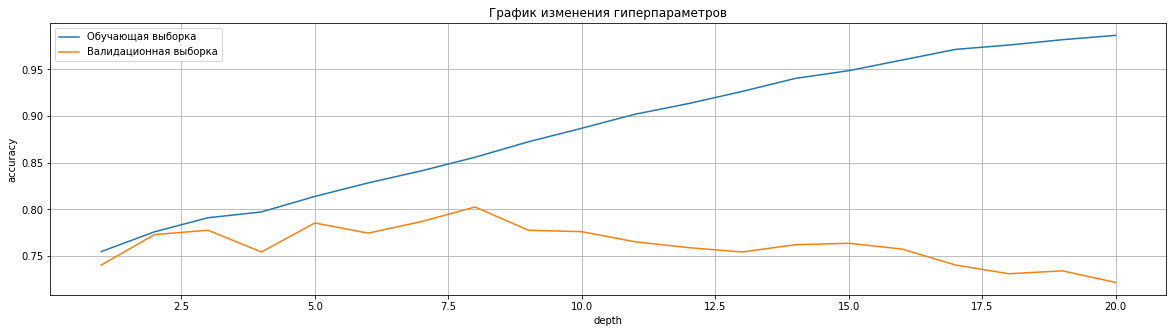

In [ ]:
plt.figure(figsize=(20, 5))
plt.grid(True)
plt.plot(depth_dt, accuracy_train_dt)
plt.plot(depth_dt, accuracy_valid_dt)
plt.legend(['Обучающая выборка', 'Валидационная выборка'])
plt.xlabel('depth')
plt.ylabel('accuracy')
plt.title('График изменения гиперпараметров')
plt.show()

In [ ]:
# tree.plot_tree(best_model)
# plt.show()

Случайный лес

In [ ]:
best_model_rf = None
best_result = 0
best_est = 0
best_depth = 0
for est in tqdm(range(1,11)):
    for depth in range(1, 11):
        model_rf = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345)
        model_rf.fit(features_train, target_train)
        result = model_rf.score(features_valid, target_valid)
        print('n_estimators =', est, '|','max_depth =',  depth, '|', 'accuracy_score =', accuracy(model_rf))
        if result > best_result:
            best_model_rf = model_rf
            best_result = result
            best_est = est
            best_depth = depth


 20%|██        | 2/10 [00:00<00:00, 10.11it/s]

n_estimators = 1 | max_depth = 1 | accuracy_score = 0.7480559875583204
n_estimators = 1 | max_depth = 2 | accuracy_score = 0.776049766718507
n_estimators = 1 | max_depth = 3 | accuracy_score = 0.776049766718507
n_estimators = 1 | max_depth = 4 | accuracy_score = 0.7558320373250389
n_estimators = 1 | max_depth = 5 | accuracy_score = 0.7713841368584758
n_estimators = 1 | max_depth = 6 | accuracy_score = 0.7791601866251944
n_estimators = 1 | max_depth = 7 | accuracy_score = 0.7791601866251944
n_estimators = 1 | max_depth = 8 | accuracy_score = 0.7884914463452566
n_estimators = 1 | max_depth = 9 | accuracy_score = 0.7682737169517885
n_estimators = 1 | max_depth = 10 | accuracy_score = 0.7791601866251944
n_estimators = 2 | max_depth = 1 | accuracy_score = 0.7153965785381027
n_estimators = 2 | max_depth = 2 | accuracy_score = 0.7573872472783826
n_estimators = 2 | max_depth = 3 | accuracy_score = 0.7900466562986003
n_estimators = 2 | max_depth = 4 | accuracy_score = 0.7729393468118196
n_estim

 40%|████      | 4/10 [00:00<00:00,  8.09it/s]

n_estimators = 4 | max_depth = 7 | accuracy_score = 0.7993779160186625
n_estimators = 4 | max_depth = 8 | accuracy_score = 0.7838258164852255
n_estimators = 4 | max_depth = 9 | accuracy_score = 0.7947122861586314
n_estimators = 4 | max_depth = 10 | accuracy_score = 0.7667185069984448
n_estimators = 5 | max_depth = 1 | accuracy_score = 0.7651632970451011
n_estimators = 5 | max_depth = 2 | accuracy_score = 0.7698289269051322
n_estimators = 5 | max_depth = 3 | accuracy_score = 0.7916018662519441
n_estimators = 5 | max_depth = 4 | accuracy_score = 0.7916018662519441
n_estimators = 5 | max_depth = 5 | accuracy_score = 0.7853810264385692
n_estimators = 5 | max_depth = 6 | accuracy_score = 0.7916018662519441
n_estimators = 5 | max_depth = 7 | accuracy_score = 0.7947122861586314
n_estimators = 5 | max_depth = 8 | accuracy_score = 0.7838258164852255
n_estimators = 5 | max_depth = 9 | accuracy_score = 0.7916018662519441


 50%|█████     | 5/10 [00:00<00:00,  7.29it/s]

n_estimators = 5 | max_depth = 10 | accuracy_score = 0.8009331259720062
n_estimators = 6 | max_depth = 1 | accuracy_score = 0.749611197511664
n_estimators = 6 | max_depth = 2 | accuracy_score = 0.7682737169517885
n_estimators = 6 | max_depth = 3 | accuracy_score = 0.7931570762052877
n_estimators = 6 | max_depth = 4 | accuracy_score = 0.7869362363919129
n_estimators = 6 | max_depth = 5 | accuracy_score = 0.7822706065318819
n_estimators = 6 | max_depth = 6 | accuracy_score = 0.7962674961119751
n_estimators = 6 | max_depth = 7 | accuracy_score = 0.7916018662519441
n_estimators = 6 | max_depth = 8 | accuracy_score = 0.7838258164852255
n_estimators = 6 | max_depth = 9 | accuracy_score = 0.7853810264385692


 60%|██████    | 6/10 [00:00<00:00,  6.37it/s]

n_estimators = 6 | max_depth = 10 | accuracy_score = 0.7962674961119751
n_estimators = 7 | max_depth = 1 | accuracy_score = 0.7651632970451011
n_estimators = 7 | max_depth = 2 | accuracy_score = 0.7776049766718507
n_estimators = 7 | max_depth = 3 | accuracy_score = 0.7962674961119751
n_estimators = 7 | max_depth = 4 | accuracy_score = 0.7900466562986003
n_estimators = 7 | max_depth = 5 | accuracy_score = 0.7869362363919129
n_estimators = 7 | max_depth = 6 | accuracy_score = 0.7947122861586314
n_estimators = 7 | max_depth = 7 | accuracy_score = 0.7978227060653188
n_estimators = 7 | max_depth = 8 | accuracy_score = 0.7900466562986003


 70%|███████   | 7/10 [00:01<00:00,  5.45it/s]

n_estimators = 7 | max_depth = 9 | accuracy_score = 0.80248833592535
n_estimators = 7 | max_depth = 10 | accuracy_score = 0.7993779160186625
n_estimators = 8 | max_depth = 1 | accuracy_score = 0.7620528771384136
n_estimators = 8 | max_depth = 2 | accuracy_score = 0.7729393468118196
n_estimators = 8 | max_depth = 3 | accuracy_score = 0.7931570762052877
n_estimators = 8 | max_depth = 4 | accuracy_score = 0.7869362363919129
n_estimators = 8 | max_depth = 5 | accuracy_score = 0.7962674961119751
n_estimators = 8 | max_depth = 6 | accuracy_score = 0.7962674961119751
n_estimators = 8 | max_depth = 7 | accuracy_score = 0.8040435458786936


 80%|████████  | 8/10 [00:01<00:00,  4.87it/s]

n_estimators = 8 | max_depth = 8 | accuracy_score = 0.7962674961119751
n_estimators = 8 | max_depth = 9 | accuracy_score = 0.807153965785381
n_estimators = 8 | max_depth = 10 | accuracy_score = 0.7978227060653188
n_estimators = 9 | max_depth = 1 | accuracy_score = 0.7511664074650077
n_estimators = 9 | max_depth = 2 | accuracy_score = 0.7776049766718507
n_estimators = 9 | max_depth = 3 | accuracy_score = 0.7947122861586314
n_estimators = 9 | max_depth = 4 | accuracy_score = 0.7931570762052877
n_estimators = 9 | max_depth = 5 | accuracy_score = 0.7947122861586314
n_estimators = 9 | max_depth = 6 | accuracy_score = 0.7962674961119751


 90%|█████████ | 9/10 [00:01<00:00,  4.46it/s]

n_estimators = 9 | max_depth = 7 | accuracy_score = 0.7962674961119751
n_estimators = 9 | max_depth = 8 | accuracy_score = 0.7947122861586314
n_estimators = 9 | max_depth = 9 | accuracy_score = 0.8055987558320373
n_estimators = 9 | max_depth = 10 | accuracy_score = 0.7962674961119751
n_estimators = 10 | max_depth = 1 | accuracy_score = 0.7542768273716952
n_estimators = 10 | max_depth = 2 | accuracy_score = 0.7744945567651633
n_estimators = 10 | max_depth = 3 | accuracy_score = 0.7947122861586314
n_estimators = 10 | max_depth = 4 | accuracy_score = 0.7947122861586314
n_estimators = 10 | max_depth = 5 | accuracy_score = 0.7900466562986003
n_estimators = 10 | max_depth = 6 | accuracy_score = 0.7993779160186625
n_estimators = 10 | max_depth = 7 | accuracy_score = 0.8009331259720062
n_estimators = 10 | max_depth = 8 | accuracy_score = 0.8009331259720062


100%|██████████| 10/10 [00:01<00:00,  5.01it/s]

n_estimators = 10 | max_depth = 9 | accuracy_score = 0.8087091757387247
n_estimators = 10 | max_depth = 10 | accuracy_score = 0.8009331259720062


In [ ]:
print("Accuracy наилучшей модели на валидационной выборке:", best_result, best_model_rf)

Accuracy наилучшей модели на валидационной выборке: 0.8087091757387247 RandomForestClassifier(max_depth=9, n_estimators=10, random_state=12345)


Логистическая регрессия

In [ ]:
sol = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

In [ ]:
best_model_lr = None
best_result = 0
for s in sol:
    model_lr = LogisticRegression(solver=s, random_state=12345)
    model_lr.fit(features_train, target_train)
    result = model_lr.score(features_valid, target_valid)
    accuracy(model_lr)
    if result > best_result:
        best_model_lr = model_lr
        best_result = result
print("Accuracy наилучшей модели на валидационной выборке:", best_result, best_model_lr)


Accuracy наилучшей модели на валидационной выборке: 0.7387247278382582 LogisticRegression(random_state=12345, solver='newton-cg')


*Дерево решений*

Accuracy наилучшей модели на валидационной выборке: 0.80248833592535 DecisionTreeClassifier(max_depth=8, random_state=12345)


*Случайный лес*

Accuracy наилучшей модели на валидационной выборке: 0.8087091757387247 RandomForestClassifier(max_depth=9, n_estimators=10, random_state=12345)


*Логистическая регрессия*

Accuracy наилучшей модели на валидационной выборке: 0.7387247278382582 LogisticRegression(random_state=12345, solver='newton-cg')


Лучшая модель - случайный лес с параметрами:

    -max_depth=9
    -n_estimators=10
    -random_state=12345

## Проверьте модель на тестовой выборке

In [ ]:
best_model_rf.fit(features_train, target_train)
predictions_test = best_model_rf.predict(features_test)
accuracy_score(target_test, predictions_test)

На тестовой выборке accuracy близок к валидационной. Модель не переобучилась и недообучилась. Хорошая модель.

## Вывод


<div class="alert alert-info">Оператор мобильной связи &laquo;Мегалайн&raquo; выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: &laquo;Смарт&raquo; или &laquo;Ультра&raquo;. В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Необходимо построить модель для задачи классификации, которая выберет подходящий тариф.
    
<p>Данные полные, без пропусков и дубликатов<p>
    
<p>В ходе работы были построены 3 модели машинного обучения:<p>
<ul>Дерево решений</ul>
<ul>Случайный лес</ul>
<ul>Логистическая регрессия</ul>
<p>В ходе подбора гиперпараметров победила модель Случайного леса.</p>
<p>Accuracy &nbsp;0.8087091757387247</p>
<p>На тестовой выборке accuracy близок к валидационной (0.8009331259720062).&nbsp;</p>
<p>Модель можно применять в продакшене.</p>
</div>